# Part-2: Gradient Descent and Genetic Algorithms applied to  PID Controller

## Introduction
In this part, I am going to consider cascading PID controllers and how to find the coefficients for that particular case. The scenario is the same as [part 1](gradient-descent-and-genetic-algorithms-applied-to-pid-controller-part-1.ipynb). We are still dealing with a simple lifter; however, the PID control diagram is more involved as shown below.

![cascading-pid](../img/simple_lifter_pid_cascading.png)

Symbols and variables used in this example are given in the table below.

| Symbol        | Explanation                    |
|:-------------:|:------------------------------:|
| $h_d(t)$      | desired height                 |
| $h_m(t)$      | measured height                |
| $h_e(t)$      | height error                   |
| $v_d(t)$      | desired velocity               |
| $v_m(t)$      | measured velocity              |
| $v_e(t)$      | velocity error                 |
| $a(t)$        | acceleration                   |
| $F(t)$        | estimated force                |
| $K_{hp}$      | height control p coefficient   |
| $K_{hi}$      | height control i coefficient   |
| $K_{hd}$      | height control d coefficient   |
| $K_{vp}$      | velocity control p coefficient |
| $K_{vi}$      | velocity control i coefficient |
| $K_{vd}$      | velocity control d coefficient |

## PID Implementation

`pid_velocity` function  takes coefficients $K_{vp}$, $K_{vi}$, $K_{vd}$, desired velocity $v_d$, mass $m$ and *duration* as arguments and return $h_m(t)$, $v_d(t)$, $v_m(t)$, $F(t)$, $t$.

`pid` function takes coefficients $K_{hp}$, $K_{hi}$, $K_{hd}$, $K_{vp}$, $K_{vi}$, $K_{vd}$,, desired height $h_d$ mass $m$ and *duration* as arguments, and returns $h_d(t)$, $h_m(t)$, $v_d(t)$, $v_m(t)$, $F(t)$, $t$, so that we can plot the graphs to observe the changes in time domain. We can also derive a cost function for gradient descent algorithm and a fitness function for genetic algortihm using the data returned by the `pid_velocity` and `pid` functions.

In [4]:
# Let printing work the same in Python 2 and 3
from __future__ import print_function
# Import required modules in this notebook
import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from ipywidgets import interact, FloatText
from matplotlib.patches import Polygon

In [181]:
def pid_velocity(Kvp, Kvi, Kvd, v_d, m=1.0, duration=15):
    # Time
    freq=1000.0 # Hz
    T = 1.0/freq
    t = np.arange(0, duration, T) # duration seconds with the freq Hz
    
    # Plot data
    hm = np.zeros_like(t)   # meter (m)
    vd = np.zeros_like(t)   # m/s
    vm = np.zeros_like(t)   # m/s
    F   = np.zeros_like(t)  # Newton(N) = kg.m/s^2
    
    # Weight
    # m  in kg
    g   = 9.8                # m/s^2
    
    # Measurement
    accel_measured_sum = 0.0
    accel_measured_cnt = 0
    velocity = 0.0
    height = 0.0
    
    # PID variables for I and D
    Ive = 0.0
    ve_prev = 0.0
    
    # Data to be saved
    force = 0.0
    v_m = 0.0
    
    for n,_ in enumerate(t):
        # 1000 Hz system loop
        # read sensors etc...
        accel_measured_sum +=  -g + force/m
        accel_measured_cnt += 1

        # 100 Hz inner loop
        if n % 10 == 0:
            period = T*10
            # estimate sensor readings
            accel = accel_measured_sum / accel_measured_cnt
            accel_measured_sum = 0
            accel_measured_cnt = 0
            #v = velocity
            velocity += accel * period
            #velocity = (velocity + v) * 0.5
            # ^ Also give this a try (trapezoidal rule)
            # see http://www.zweigmedia.com/RealWorld/integral/numint.html
            height += velocity * period
            if height < 0:
                h_m = 0
                v_m = 0
                velocity = 0
            else:
                h_m = height
                v_m = velocity
                
            v_e = v_d - v_m
            #I = Ive
            Ive += Kvi*v_e*period
            #Ive = (Ive + I)*0.5
            # ^ Also give this a try (trapezoidal rule)
            # see http://www.zweigmedia.com/RealWorld/integral/numint.html
            Ive = min(Ive, 15)
            Ive = max(Ive,-15)
            force = Kvp*v_e + Ive + Kvd*(v_e - ve_prev)/period
            force = min(force, 15)
            force = max(force,-15)
            ve_prev = v_e
        
        # Save for plotting
        F[n] = force
        vd[n] = v_d
        hm[n] = h_m
        vm[n] = v_m
        
    return (hm, vd, vm, F, t)

def pid(Khp, Khi, Khd, Kvp, Kvi, Kvd, h_d, m=1.0, duration=15):
    
    # Time
    freq=1000.0 # Hz
    T = 1.0/freq
    t = np.arange(0, duration, T) # duration seconds with freq Hz

    # Plot data
    hd  = np.zeros_like(t)  # meter(m)
    hm  = np.zeros_like(t)  # meter(m) 
    vd = np.zeros_like(t)   # m/s
    vm = np.zeros_like(t)   # m/s   
    F   = np.zeros_like(t)  # Newton(N) = kg.m/s^2
   
    # Weight
    # m   in kg
    g   = 9.8                # m/s^2

    # Measurement
    accel_measured_sum = 0.0
    accel_measured_cnt = 0
    velocity = 0.0
    height = 0.0

    # PID variables for I and D
    Ihe = 0.0
    Ive = 0.0
    he_prev = 0.0
    ve_prev = 0.0
    
    # Data to be saved
    force = 0.0
    h_m = 0.0
    v_m = 0.0
    v_d = 0.0

    for n,_ in enumerate(t):
        # 1000 Hz system loop
        # read sensors etc...
        accel_measured_sum +=  -g + force/m
        accel_measured_cnt += 1

        # 50 Hz outer loop
        if  n % 20 == 0:
            period = T*20.0
            h_e = h_d - h_m
            #I = Ihe
            Ihe += Khi*h_e*period
            #Ihe = (Ihe + I)*0.5
            # ^ Also give this a try (trapezoidal rule)
            # see http://www.zweigmedia.com/RealWorld/integral/numint.html
            Ihe = min(Ihe, 5)
            Ihe = max(Ihe, -5)
            v_d = Khp*h_e + Ihe + Khd*(h_e - he_prev)/period
            v_d = min(v_d, 5)
            v_d = max(v_d,-5)
            he_prev = h_e

        # 100 Hz inner loop
        if n % 10 == 0:
            period = T*10.0
            # estimate sensor readings
            accel = accel_measured_sum / accel_measured_cnt
            accel_measured_sum = 0
            accel_measured_cnt = 0
            #v = velocity
            velocity += accel * period
            #velocity = (velocity + v) * 0.5
            # ^ Also give this a try (trapezoidal rule)
            # see http://www.zweigmedia.com/RealWorld/integral/numint.html
            height += velocity * period
            if height < 0:
                h_m = 0
                v_m = 0
                velocity = 0
            else:
                h_m = height
                v_m = velocity
                
            v_e = v_d - v_m
            #I = Ive
            Ive += Kvi*v_e*period
            #Ive = (Ive + I)*0.5
            # ^ Also give this a try (trapezoidal rule)
            # see http://www.zweigmedia.com/RealWorld/integral/numint.html
            Ive = min(Ive, 15)
            Ive = max(Ive,-15)
            force = Kvp*v_e + Ive + Kvd*(v_e - ve_prev)/period
            force = min(force, 15)
            force = max(force,-15)
            ve_prev = v_e
        
        # Save for plotting
        F[n] = force
        hd[n] = h_d
        vd[n] = v_d
        hm[n] = h_m
        vm[n] = v_m
        
    return (hd, hm, vd, vm, F, t)

## Plotting
Let's plot the data returned from the pid function for some coefficients.

<IPython.core.display.Javascript object>


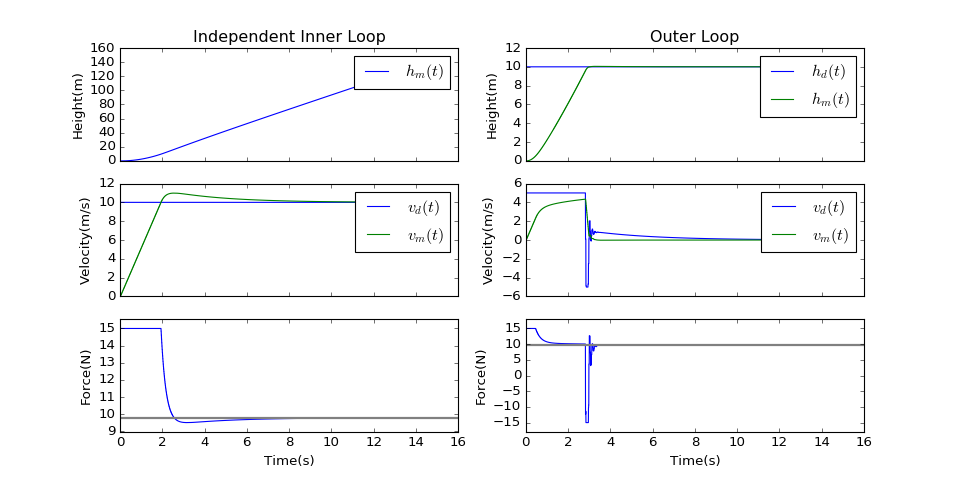

In [191]:
def pid_plot(Khp, Khi, Khd, Kvp, Kvi, Kvd, v_d, h_d, m):
    fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=plt.figaspect(0.5))
    (hm, vd, vm, F, t) = pid_velocity(Kvp, Kvi, Kvd, v_d, m)
    axes[0,0].set_title('Independent Inner Loop')
    axes[0,0].plot(t, hm, label='$h_m(t)$')
    axes[0,0].set_ylabel('Height(m)')
    axes[0,0].legend()
    axes[1,0].plot(t, vd, label='$v_d(t)$')
    axes[1,0].plot(t, vm, label='$v_m(t)$')
    axes[1,0].set_ylabel('Velocity(m/s)')
    axes[1,0].legend()
    axes[2,0].plot(t, F)
    axes[2,0].set_ylabel('Force(N)')
    axes[2,0].set_xlabel('Time(s)')
    axes[2,0].axhline(9.8, color='gray', linewidth=2)
    axes[2,0].margins(y=0.1)
    (hd, hm, vd, vm, F, t) = pid(Khp, Khi, Khd, Kvp, Kvi, Kvd, h_d, m)
    axes[0,1].set_title('Outer Loop')
    axes[0,1].plot(t, hd, label='$h_d(t)$')
    axes[0,1].plot(t, hm, label='$h_m(t)$')
    axes[0,1].set_ylabel('Height(m)')
    axes[0,1].legend()
    axes[1,1].plot(t, vd, label='$v_d(t)$')
    axes[1,1].plot(t, vm, label='$v_m(t)$')
    axes[1,1].set_ylabel('Velocity(m/s)')
    axes[1,1].legend()
    axes[2,1].plot(t, F)
    axes[2,1].set_ylabel('Force(N)')
    axes[2,1].set_xlabel('Time(s)')
    axes[2,1].axhline(9.8, color='gray', linewidth=2)
    axes[2,1].margins(y=0.1)
    plt.show()
    
interact(pid_plot, 
              Khp=FloatText(69.0, description=r'$K_{hp}$'),
              Khi=FloatText(43.8, description=r'$K_{hi}$'),
              Khd=FloatText(8.0, description=r'$K_{hd}$'),
              Kvp=FloatText(4.56, description=r'$K_{vp}$'),
              Kvi=FloatText(1.55, description=r'$K_{vi}$'),
              Kvd=FloatText(0.0, description=r'$K_{vd}$'),
              v_d=FloatText(10.0, description=r'$v_d$'),
              h_d=FloatText(10.0, description=r'$h_d$'),
              m  =FloatText(1.0, description=r'mass'))
#pid_plot(69.12304290436215, 43.82416773889, 7.925091303547, 4.5678945783, 1.553189, 0.0, 10, 10)
#pid_plot(76.08772255,   7.89624848,  14.90158899,   3.66298288,   3.38159228,   0.0, 10, 10)

## Animation

It is also nice to see the animation of the motion with different PID coefficients.

<IPython.core.display.Javascript object>


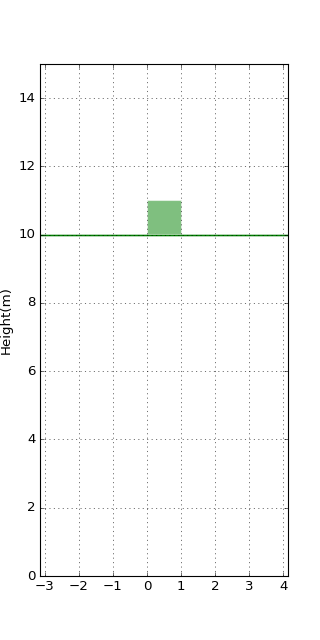

In [184]:
(hd, hm, vd, vm, F, t) = pid(69.1230, 43.824, 7.92509, 4.567894, 1.553189, 0.0, 10.0)
h = hd[-1]
verts = np.array([[0.0, 0.0], [0.0, h*0.1], [h*0.1, h*0.1], [h*0.1, 0.0]])
fig, ax = plt.subplots(figsize=plt.figaspect(2.0))
square = ax.add_patch(plt.Polygon(verts, fc='g', ec='w', alpha=0.5))
def init_animation():
    ax.grid(True)
    ax.axhline(y=h, linewidth=1, color='g')
    ax.axis('equal')
    ax.set_ylabel('Height(m)')
    ax.set_xlim(-h*0.1, h*0.2)
    ax.set_ylim(0, 1.5*h)

def animate(height):
        verts[0][1] = height
        verts[1][1] = height + h*0.1
        verts[2][1] = height + h*0.1
        verts[3][1] = height
        square.set_xy(verts)
        return square

ani = matplotlib.animation.FuncAnimation(fig, animate, hm[0:-1:200], init_func=init_animation, blit=True)
#ani.save('/tmp/pid_animation.gif', writer='imagemagick', fps=30)
plt.show()

## Gradient Descent Algorithm for PID Tuning
Following formulation is adopted for gradient descent algorithm in this part.
$$\begin{align}
\vec{\mathbf{H}}_n & = (K_{hp}, K_{hi}, K_{hd}) \\
\vec{\mathbf{V}}_n & = (K_{vp}, K_{vi}, K_{vd}) \\
\vec{\mathbf{C}}_n & = (\vec{\mathbf{H}}_n, \vec{\mathbf{V}}_n) \\
J(\vec{\mathbf{C}}_n) & = \frac{1}{t_f-t_0}\int_{t_0}^{t_f}h_e^2(t)\mathrm{d}t  \\
J_v(\vec{\mathbf{V}}_n) & = \frac{1}{t_f-t_0}\int_{t_0}^{t_f}v_e^2(t)\mathrm{d}t  \\
\vec{\mathbf{C}}_{n+1} & = \vec{\mathbf{C}}_n - \big(\alpha \nabla J(\vec{\mathbf{H}}_n),\ \beta \nabla J_v(\vec{\mathbf{V}}_n)\big)
\end{align}$$

$J(\vec{\mathbf{C}}_n)$ is the cost of outer loop when its set point is 1 meter. 
$J_v(\vec{\mathbf{V}}_n)$ is the cost of the inner loop when its set point is 10 m/s. We try to minimize the cost of inner loop independent of outer loop. $\alpha$ and $\beta$ are the step sizes of outer and inner loops, respectively.
See [part 1](gradient-descent-and-genetic-algorithms-applied-to-pid-controller-part-1.ipynb) for more on gradient descent algorithm.

In [156]:
def J(C):
    # raise 1 meter
    (hd, hm, vd, vm, _, t) = pid(C[0], C[1], C[2], C[3], C[4], C[5], 1.0)
    he = hd - hm
    tf = t[-1]
    t0 = t[0]
    return (1.0/(tf - t0)) * sum(he**2)

def Jv(C):
    # increase the speed up to 10 m/s
    (hm, vd, vm, _, t) = pid_velocity(C[3], C[4], C[5], 20)
    ve = vd - vm
    tf = t[-1]
    t0 = t[0]
    return (1.0/(tf - t0)) * sum(ve**2)

def gradient_descent_algorithm(C, alpha=0.0001, beta=0.0001, delta=0.001, iteration=1000):
    costs = np.zeros(iteration)
    costs[0] = J(C)
    
    for n in range(1, iteration):
        grad = np.array([(J(C + [delta, 0, 0, 0, 0, 0]) - J(C - [delta, 0, 0, 0, 0, 0]))/(2.0*delta),
                         (J(C + [0, delta, 0, 0, 0, 0]) - J(C - [0, delta, 0, 0, 0, 0]))/(2.0*delta),
                         (J(C + [0, 0, delta, 0, 0, 0]) - J(C - [0, 0, delta, 0, 0, 0]))/(2.0*delta),
                         (Jv(C + [0, 0, 0, delta, 0, 0]) - Jv(C - [0, 0, 0, delta, 0, 0]))/(2.0*delta),
                         (Jv(C + [0, 0, 0, 0, delta, 0]) - Jv(C - [0, 0, 0, 0, delta, 0]))/(2.0*delta),
                         #(Jv(C + [0, 0, 0, 0, 0, delta]) - Jv(C - [0, 0, 0, 0, 0, delta]))/(2.0*delta)
                         0.0 # It seems Kvd = 0 helps it converge to better coefficients
                        ])
        C = C - np.array([alpha, alpha, alpha, beta, beta, beta]) * grad
        costs[n] = J(C)
    return (costs, C)

first coeffs:  [ 76.08665481   7.89888481  14.90513506   1.98652762   1.39951404   0.        ] 47.8454151029


<IPython.core.display.Javascript object>


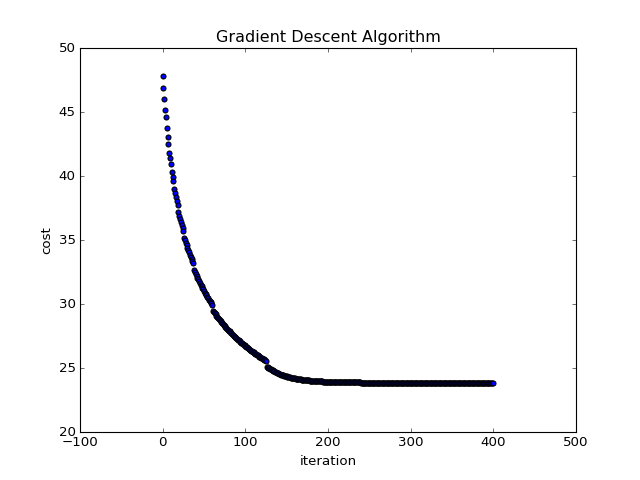

last coeffs:  [ 76.08772255   7.89624848  14.90158899   3.66298288   3.38159228   0.        ] 23.85416373


In [160]:
#C = np.random.rand(6)*10
#C = np.array([51,51,10,1.8,1.6, 0.0])
C = np.concatenate((np.random.rand(3)*80, np.random.rand(3)*2), axis=0)
C[5] = 0.0 # It seems Kvd = 0 helps it converge to better coefficients
print('first coeffs: ', C, J(C))
(costs, C) = gradient_descent_algorithm(C, alpha=0.0001, beta=0.0001, delta=0.00001, iteration=400)
fig, ax = plt.subplots()
ax.scatter(range(0, len(costs)), costs)
ax.set_title('Gradient Descent Algorithm')
ax.set_xlabel('iteration')
ax.set_ylabel('cost')
ax.set_xlim(left=0.0)
#ax.set_ylim(bottom=0.0, top=100.0)
plt.show()
print('last coeffs: ', C, J(C))

## Genetic Algorithm for PID Tuning

An individual (i.e. chromosome) is represented by following equation. 
$$\begin{align}
\vec{\mathbf{C}}_n & = (K_{hp}, K_{hi}, K_{hd}, K_{vp}, K_{vi}, K_{vd})
\end{align}$$
This is exactly the same as gradient descent's $\vec{\mathbf{C}}_n$ above. Fitness function makes use of the cost function $J(\vec{\mathbf{C}}_n)$ defined for gradient descent algorithm. Fitness is given by
$$\begin{align}
F(\vec{\mathbf{C}}_n) & = \frac{1}{J(\vec{\mathbf{C}}_n) + 1}
\end{align}$$

We select two individual for crossover. One is the best-fit individual and the other is selected through the roulette wheel selection method. A one-point mutation operation is also used with a low probability(5%) after crossover.

In [165]:
## Fitness calculated using the cost function.
def fitness(individual):
    c = J(individual)
    f = 1.0/(c + 1.0)
    return (c, f)
    
# Best-fit and Roulette Wheel Selections
def select(population, fitnesses):
    cumulative = sum(fitnesses)

    index1 = fitnesses.index(max(fitnesses))
    index2 = 0
    s = 0
    r = np.random.rand() * cumulative # [0, cumulative)
    for i, f in enumerate(fitnesses):
        if s >= r:
            index2 = i
            break;
        s += f
    return (population[index1], population[index2])

# Three-point crossover
def crossover(individual1, individual2):
    individual = [0.0, 0.0, 0.0, 0.0, 0.0 ,0.0]
    r = np.random.rand()
    individual[0] = individual2[0]*r + individual1[0]*(1.0-r)
    r = np.random.rand()
    individual[1] = individual2[1]*r + individual1[1]*(1.0-r)
    r = np.random.rand()
    individual[2] = individual2[2]*r + individual1[2]*(1.0-r)
    r = np.random.rand()
    individual[3] = individual2[3]*r + individual1[3]*(1.0-r)
    r = np.random.rand()
    individual[4] = individual2[4]*r + individual1[4]*(1.0-r)
    r = np.random.rand()
    individual[5] = individual2[5]*r + individual1[5]*(1.0-r)
    return individual

# Muatation with probability of 5%
def mutate(individual):
    if np.random.randint(0, 100) < 5:
        i = np.random.randint(0, len(individual))
        k = np.random.rand() * 2.0
        individual[i] *= k
    return individual
    
# Genetic algorithm loop
def genetic_algorithm(population, iteration=100):
    costs = [fitness(individual)[0] for individual in population]
    fitnesses = [fitness(individual)[1] for individual in population]
    for i in range(iteration):
        (individual1, individual2) = select(population, fitnesses)
        individual = crossover(individual1, individual2)
        individual = mutate(individual)
        (c, f) = fitness(individual)
        population.append(individual) 
        fitnesses.append(f)
        costs.append(c)
    return (costs, fitnesses, population[fitnesses.index(max(fitnesses))])

best:  [69.12304290436215, 43.82416773889696, 7.925091303547072, 4.567894578307471, 1.5531894407130025, 0.0] 22.9747145117


<IPython.core.display.Javascript object>


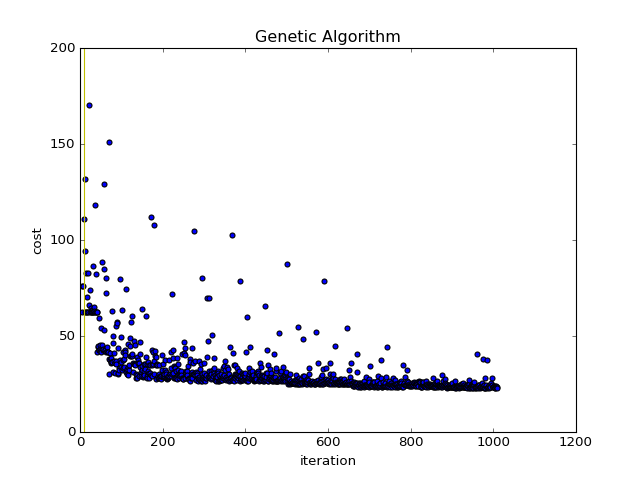

In [169]:
# Randomly generate individuals
population = np.concatenate((np.random.rand(10,3)*80, np.random.rand(10,3)*2), axis=1).tolist()
#population = (np.random.rand(10,6)*40).tolist()
for p in population:
    p[5] = 0.0 # It seems Kvd = 0 helps it converge to better coefficients
(costs, fitnesses, best) = genetic_algorithm(population, iteration=1000)
print('best: ', best, (J(best)))
fig, ax = plt.subplots()
ax.scatter(range(0, len(costs)), costs)
ax.axvline(x=10, linewidth=1, color='y')
ax.set_title('Genetic Algorithm')
ax.set_xlabel('iteration')
ax.set_ylabel('cost')
ax.set_xlim(left=0.0)
ax.set_ylim(bottom=0.0, top=200.0)
plt.show()

## Concluding Remarks

- When $K_{vd}$ is zero, cascading control system tends to perform better with the coefficients found by means of the given algorithms.
- Once coefficients are tuned, cascading PID controller performs better against changing desired height values compared to the controller in [part 1](gradient-descent-and-genetic-algorithms-applied-to-pid-controller-part-1.ipynb)